In [19]:
import pandas as pd
import numpy as np

customers = pd.read_excel('Manta customers.xlsx')
sales = pd.read_excel('Manta product sales per month.xlsx')
products = pd.read_excel('Manta products.xlsx')

display(customers.head())
display(sales.head())
display(products.head())





,Retailer Code,ZIP,Country,City,Shop Type
0,FRLEQAUR01,31,FR,Toulouse,fashion
1,FRFEEPER01,66,FR,PERPIGNAN,concept_store
2,FRCOTCAN01,6400,FR,Cannes,"gifts,home/decoration"
3,FRSOLPER01,6600,FR,PERPIGNAN,food/drinks
4,FRTERTRO01,10000,FR,Troyes,home/decoration


,brand,sku,2024 09-Sep Euro,2024 10-Oct Euro,2024 11-Nov Euro,2024 12-Dec Euro,2025 01-Jan Euro,2025 02-Feb Euro,2025 03-Mar Euro,2025 04-Apr Euro,2025 05-May Euro,2025 06-Jun Euro,2025 07-Jul Euro,2025 08-Aug Euro,SoldItems
0,Winkee,11849,24.0,108.0,36.0,132.0,72.0,12.0,12.0,42.0,48.0,72.0,NaN,NaN,558
1,Winkee,12364,96.0,24.0,96.0,12.0,48.0,24.0,12.0,NaN,NaN,12.0,24.0,NaN,348
2,Winkee,13407,48.0,48.0,12.0,36.0,12.0,NaN,36.0,30.0,12.0,NaN,12.0,NaN,246
3,Winkee,14925,60.0,NaN,60.0,20.0,20.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,190
4,Winkee,16117,16.0,NaN,16.0,32.0,48.0,32.0,NaN,16.0,NaN,NaN,NaN,NaN,160


,sku,brand_name,ean,name,short_description,description,launch_season
0,BF27 PASTEL BLUE,Asobu,842591057199,Aspen Bottle Pastel Blue,NaN,NaN,2024.2
1,BF27 PASTEL GREEN,Asobu,842591057168,Aspen Bottle Pastel Green,NaN,NaN,2024.2
2,BF27 PASTEL PEACH/ORANGE,Asobu,842591057182,Aspen Bottle Pastel Peach/Orange,NaN,NaN,2024.2
3,BF27 PASTEL PINK,Asobu,842591057205,Aspen Bottle Pastel Pink,NaN,NaN,2024.2
4,BF52 PASTEL BLUE,Asobu,842591057274,Coffee Express Tumbler Pastel Blue,NaN,NaN,2024.2


In [40]:
print(sales.columns.tolist())
print(customers.columns.tolist())
print(products.columns.tolist())

['brand', 'sku', '2024 09-Sep Euro', '2024 10-Oct Euro', '2024 11-Nov Euro', '2024 12-Dec Euro', '2025 01-Jan Euro', '2025 02-Feb Euro', '2025 03-Mar Euro', '2025 04-Apr Euro', '2025 05-May Euro', '2025 06-Jun Euro', '2025 07-Jul Euro', '2025 08-Aug Euro', 'SoldItems']
['Retailer Code', 'ZIP', 'Country', 'City', 'Shop Type']
['sku', 'brand_name', 'ean', 'name', 'short_description', 'description', 'launch_season']


In [ ]:
sales["sku"] = sales["sku"].astype(str)
products["sku"] = products["sku"].astype(str)



In [31]:
#Pivot table Retailer Code x SKU 
pivot = sales.pivot_table(
    index="Retailer Code",     # elke winkel / klant
    columns="sku",             # elk product
    values="SoldItems",        # aantal verkochte items
    fill_value=0
)

#Cosine similarity berekenen 
product_similarity = pd.DataFrame(
    cosine_similarity(pivot.T),
    index=pivot.columns,
    columns=pivot.columns
)

# --- Heatmap visualisatie ---
plt.figure(figsize=(8,6))
sns.heatmap(product_similarity, cmap="coolwarm", annot=False)
plt.title("Product Cosine Similarity")
plt.show()

# --- Aanbevelingsfunctie ---
def recommend_products(sku, top_n=3):
    """Geeft top-N meest vergelijkbare producten terug op basis van cosine similarity."""
    if sku not in product_similarity.columns:
        print(f"⚠️ SKU {sku} niet gevonden in de data.")
        return pd.DataFrame()
    
    similar = product_similarity[sku].sort_values(ascending=False)[1:top_n+1]
    return similar.reset_index().rename(columns={"index": "sku", sku: "similarity"})

# --- Voorbeeld: aanbevelingen voor een product ---
top_recommendations = recommend_products("BF27 PASTEL GREEN")

# --- Koppelen met productinfo ---
recommended_products = top_recommendations.merge(products, on="sku", how="left")

# --- Resultaat tonen ---
print(recommended_products[["sku", "name", "brand_name", "similarity"]])


KeyError: 'Retailer Code'

## 1.Cosine similarity tussen producten
Doel: uitvinden welke producten vaak samen worden gekocht door winkels.
welke producten lijken qua koopgedrag op elkaar of te wel “Winkels die product X kochten, kochten ook product Y.”


In [21]:
import pandas as pd

#product-verkoopmatrix
data = {
    'Retailer Code': ['A', 'A', 'B', 'B', 'C', 'C'],
    'sku': ['BF27 PASTEL BLUE', 'BF27 PASTEL GREEN', 'BF27 PASTEL BLUE', 
            'BF52 PASTEL BLUE', 'BF27 PASTEL GREEN', 'BF52 PASTEL BLUE'],
    'SoldItems': [10, 5, 3, 8, 6, 7]
}
df = pd.DataFrame(data)
print(df)
#omzetten naar matrix met retailers als rijen en producten als kolommen
pivot = df.pivot_table(index='Retailer Code', columns='sku', values='SoldItems', fill_value=0)
print(pivot)


#De gemiddelde verkopen per shop type
#hierbij gebruiken we cosine similarity, kijkt naar als winkels vaak dezelfde producten samen kopen, 
#zullen de vectoren veel overlap hebben → hoge similarity (dicht bij 1)
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# transpose want we willen similarity tussen producten, niet tussen retailers
product_similarity = pd.DataFrame(
    cosine_similarity(pivot.T),
    index=pivot.columns,
    columns=pivot.columns
)

print(product_similarity)

# Uit de output kan je zien dat het product BF27 PASTEL GREEN een beetje in het midden zit
# en wordt het vaakst samen gekocht met zowel BF27 PASTEL BLUE als BF52 PASTEL BLUE.
# Dat maakt het een “verbinder” tussen de twee productgroepen.

  Retailer Code                sku  SoldItems
0             A   BF27 PASTEL BLUE         10
1             A  BF27 PASTEL GREEN          5
2             B   BF27 PASTEL BLUE          3
3             B   BF52 PASTEL BLUE          8
4             C  BF27 PASTEL GREEN          6
5             C   BF52 PASTEL BLUE          7
sku            BF27 PASTEL BLUE  BF27 PASTEL GREEN  BF52 PASTEL BLUE
Retailer Code                                                       
A                            10                  5                 0
B                             3                  0                 8
C                             0                  6                 7
sku                BF27 PASTEL BLUE  BF27 PASTEL GREEN  BF52 PASTEL BLUE
sku                                                                     
BF27 PASTEL BLUE           1.000000           0.613185          0.216251
BF27 PASTEL GREEN          0.613185           1.000000          0.505877
BF52 PASTEL BLUE           0.216251      

### Aanbeveling ophalen

In [22]:
#aanbeveling ophalen

#functie die voor een prodcut de meest vergelijkbare producten laat zien
#def recommend_products(sku, top_n=3):
 #   if sku not in product_similarity:
  #      return []
   # similar = product_similarity[sku].sort_values(ascending=False)[1:top_n+1]
    #return similar

#print(recommend_products('1002'))



# Dus als een winkel het product BF27 PASTEL GREEN koopt,
# kun je BF27 PASTEL BLUE als eerste aanbeveling tonen
# gevolgd door BF52 PASTEL BLUE als tweede aanbeveling (cosine similarity = 0.51).

In [23]:
def recommend_products(product_name, top_n=3):
    if product_name not in product_similarity:
        return pd.DataFrame(columns=['sku','similarity'])  # lege df met juiste kolommen
    similar = product_similarity[product_name].sort_values(ascending=False)[1:top_n+1]
    return pd.DataFrame({
        'sku': similar.index,
        'similarity': similar.values
    })


## 2.Gemiddelde verkopen per shop type
Doel: om aanbevelingen per winkeltype te personaliseren.


In [24]:
#merge met shop type
#customers = pd.read_excel('Manta customers.xlsx')
#sales = pd.read_excel('Manta product sales per month.xlsx')

# voorbeeld merge
#merged = sales.merge(customers[['Retailer Code', 'Shop Type']], on='Retailer Code', how='left')
#merged = sales.merge(customers, on='Retailer Code', how='left')



In [25]:
#import numpy as np

#sales['Retailer Code'] = np.random.choice(customers['Retailer Code'], size=len(sales))
#merged = sales.merge(customers[['Retailer Code', 'Shop Type']], on='Retailer Code', how='left')


### product informatie koppelen

In [26]:
# producten info koppelen
products['sku'] = products['sku'].astype(str)
recommendations = recommend_products('BF27 PASTEL GREEN')

# inclusief het originele product erbij
all_skus = ['BF27 PASTEL GREEN'] + recommendations['sku'].tolist()
recommended_products = products[products['sku'].isin(all_skus)]

# merge met similarity scores voor overzicht
recommended_products = recommended_products.merge(
    recommendations.rename(columns={'similarity':'similarity_score'}),
    left_on='sku',
    right_on='sku',
    how='left'
)

# zet het originele product met similarity=1 erbij
recommended_products.loc[recommended_products['sku']=='BF27 PASTEL GREEN', 'similarity_score'] = 1.0

print(recommended_products[['sku','name','brand_name','similarity_score']])


                 sku                                name brand_name  \
0   BF27 PASTEL BLUE            Aspen Bottle Pastel Blue      Asobu   
1  BF27 PASTEL GREEN           Aspen Bottle Pastel Green      Asobu   
2   BF52 PASTEL BLUE  Coffee Express Tumbler Pastel Blue      Asobu   

   similarity_score  
0          0.613185  
1          1.000000  
2          0.505877  


### Visualisatie

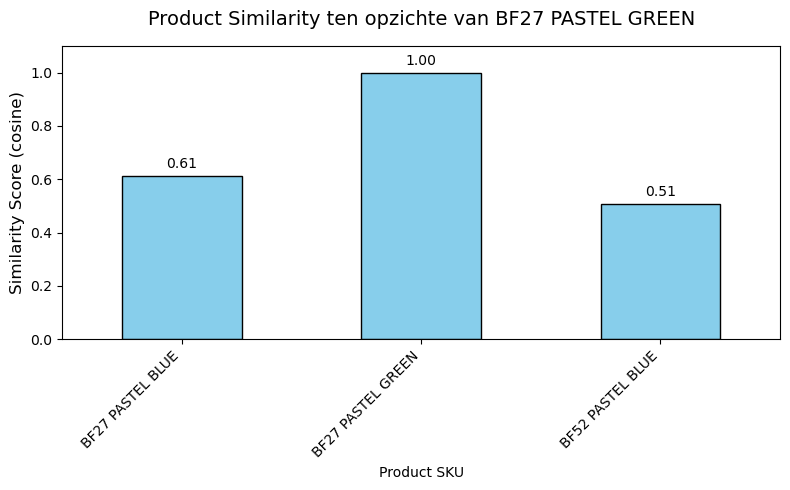

In [27]:
import matplotlib.pyplot as plt


data = recommended_products[['sku', 'similarity_score']].set_index('sku')


plt.figure(figsize=(8,5))
data['similarity_score'].plot(kind='bar', color='skyblue', edgecolor='black')


plt.title('Product Similarity ten opzichte van BF27 PASTEL GREEN', fontsize=14, pad=15)
plt.xlabel('Product SKU')
plt.ylabel('Similarity Score (cosine)', fontsize=12)
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')


for index, value in enumerate(data['similarity_score']):
    plt.text(index, value + 0.03, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()
